# PART 2: EXPLORATORY DATA ANALYSIS

**Objective:** This notebook will explore the generated datasets to draw insights from the patient visits and any relationships between date/times to inform our scheduling & streaming models.

---

In [1]:
# Data Management
import numpy as np
import pandas as pd

# Data Visualization
import geopandas as gpd
import folium
import folium.plugins as plugins
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Utils
import ipywidgets as widgets
import random
import warnings
from datetime import datetime, timedelta
from IPython.display import display, HTML
from ipywidgets import interact, interact_manual
from time import sleep
%matplotlib inline
sns.set_style('white')
sns.set_color_codes()
plt.style.use('default')
warnings.filterwarnings("ignore")

---
---

## 2A: Setup

**Objective**: Read in patients and clinic data for exploratory analysis.

---

In [2]:
patients_df = pd.read_csv('./uc_past_patients.csv', index_col='pt_id')
patients_df

pt_name      pt_dob  pt_age visit_location    visit_reason  \
pt_id                                                                          
1000016   Anthony Johnson  1966-05-27      55         denver     vaccination   
1000017      Laura Wright  2010-08-21      11         denver       ache/pain   
1000008     Karen Donovan  1998-05-03      24         denver     sore-throat   
1000014        Janet Rowe  2003-10-18      18         denver  cold/flu/fever   
1000019    Jeffrey Landry  1997-10-13      24         denver           cough   
...                   ...         ...     ...            ...             ...   
5023104      James Henson  1944-10-19      77       lakewood    rash/allergy   
5023098     Carlos Brewer  1972-05-30      49       lakewood    cuts/abscess   
5023099      Cheryl Watts  2005-02-04      17       lakewood  cold/flu/fever   
5023102         Paul Buck  2003-02-04      19       lakewood     sore-throat   
5023100  Benjamin Watkins  1972-05-30      49       lakewood        lab-work   

         visit_code  visit_date visit_day checkin_time checkout_time  \
pt_id                                                                  
1000016           3  2021-05-01  Saturday     09:47:09      10:01:09   
1000017           4  2021-05-01  Saturday     10:51:09      11:28:09   
1000008           4  2021-05-01  Saturday     10:53:24      11:33:24   
1000014           4  2021-05-01  Saturday     10:58:30      12:07:30   
1000019           4  2021-05-01  Saturday     11:07:11      12:02:11   
...             ...         ...       ...          ...           ...   
5023104           5  2022-04-30  Saturday     19:42:10      20:32:58   
5023098           5  2022-04-30  Saturday     19:48:05      20:41:05   
5023099           4  2022-04-30  Saturday     19:49:17      21:01:29   
5023102           4  2022-04-30  Saturday     19:51:05      20:34:17   
5023100           3  2022-04-30  Saturday     19:53:19      20:42:19   

         rolling_ct  rolling_code  assigned_num_techs  needed_num_techs  
pt_id                                                                    
1000016           1           0.0                   5                 1  
1000017           1           0.0                   5                 1  
1000008           2           4.0                   5                 1  
1000014           3           4.0                   5                 1  
1000019           4           4.0                   5                 2  
...             ...           ...                 ...               ...  
5023104           9           4.4                   4                 3  
5023098           9           4.5                   4                 3  
5023099          10           4.6                   4                 4  
5023102          10           4.6                   4                 4  
5023100          11           4.5                   4                 4  

[109363 rows x 14 columns]

In [3]:
clinics_df = pd.read_csv('./uc_clinics.csv', index_col='branch_name')
clinics_df

lat         lon  to_denver  to_edgewater  to_wheatridge  \
branch_name                                                                  
denver       39.739064 -104.989697          0            12             14   
edgewater    39.753954 -105.067788         14             0              5   
wheatridge   39.766857 -105.081983         14             5              0   
rino         39.767328 -104.981132          6            14             14   
lakewood     39.704552 -105.079883         12             8              8   

             to_rino  to_lakewood  \
branch_name                         
denver             7           14   
edgewater         12            9   
wheatridge        10            9   
rino               0           14   
lakewood          12            0   

                                                nearby_clinics  
branch_name                                                     
denver       [('rino', 7.0), ('edgewater', 12.0), ('wheatri...  
edgewater    [('wheatridge', 5.0), ('lakewood', 9.0), ('rin...  
wheatridge   [('edgewater', 5.0), ('lakewood', 9.0), ('rino...  
rino         [('denver', 6.0), ('edgewater', 14.0), ('wheat...  
lakewood     [('edgewater', 8.0), ('wheatridge', 8.0), ('de...

---
---

## 2B: Initial Explorations

**Objective**: Conduct initial explorations on the raw data without further aggregation or feature engineering.

---

#### Examine data characteristics & summary statistics of patient records:

In [4]:
patients_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109363 entries, 1000016 to 5023100
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pt_name             109363 non-null  object 
 1   pt_dob              109363 non-null  object 
 2   pt_age              109363 non-null  int64  
 3   visit_location      109363 non-null  object 
 4   visit_reason        109363 non-null  object 
 5   visit_code          109363 non-null  int64  
 6   visit_date          109363 non-null  object 
 7   visit_day           109363 non-null  object 
 8   checkin_time        109363 non-null  object 
 9   checkout_time       109363 non-null  object 
 10  rolling_ct          109363 non-null  int64  
 11  rolling_code        109363 non-null  float64
 12  assigned_num_techs  109363 non-null  int64  
 13  needed_num_techs    109363 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 12.5+ MB


In [5]:
# Get descriptive stats of continuous variables
patients_df[['pt_age', 'rolling_ct']].describe()

pt_age     rolling_ct
count  109363.000000  109363.000000
mean       34.461948       5.768679
std        20.854109       2.873356
min         0.000000       1.000000
25%        18.000000       4.000000
50%        32.000000       5.000000
75%        50.000000       8.000000
max        80.000000      21.000000

#### Visually explore value counts & distributions:

In [6]:
fig = make_subplots(
    rows=1, cols=2, 
    specs=[[{'type':'domain'}, {'type':'xy'}]], 
    column_widths=[0.35, 0.65], 
    subplot_titles=['Patient Distribution by Clinic', 'Location Breakdown by Severity']
)

# Construct pie-chart based on patient count for each clinic location
location_counts = patients_df['visit_location'].value_counts()
pie = go.Pie(values=location_counts, labels=location_counts.index.str.capitalize(), textinfo='label+percent', showlegend=False)

# Construct histogram for patient count by location stratified by severity level
hist1 = go.Histogram(x=patients_df[patients_df.visit_code==3]['visit_location'], name='Level 3', marker_color='khaki')
hist2 = go.Histogram(x=patients_df[patients_df.visit_code==4]['visit_location'], name='Level 4', marker_color='coral')
hist3 = go.Histogram(x=patients_df[patients_df.visit_code==5]['visit_location'], name='Level 5', marker_color='firebrick')

# Add subplots to figure object
fig.add_trace(pie, row=1, col=1)
fig.add_trace(hist3, row=1, col=2)
fig.add_trace(hist2, row=1, col=2)
fig.add_trace(hist1, row=1, col=2)

# Output figure with custom modifications
fig.update_layout(height=600, width=1100, showlegend=True, barmode='stack')
fig.show()

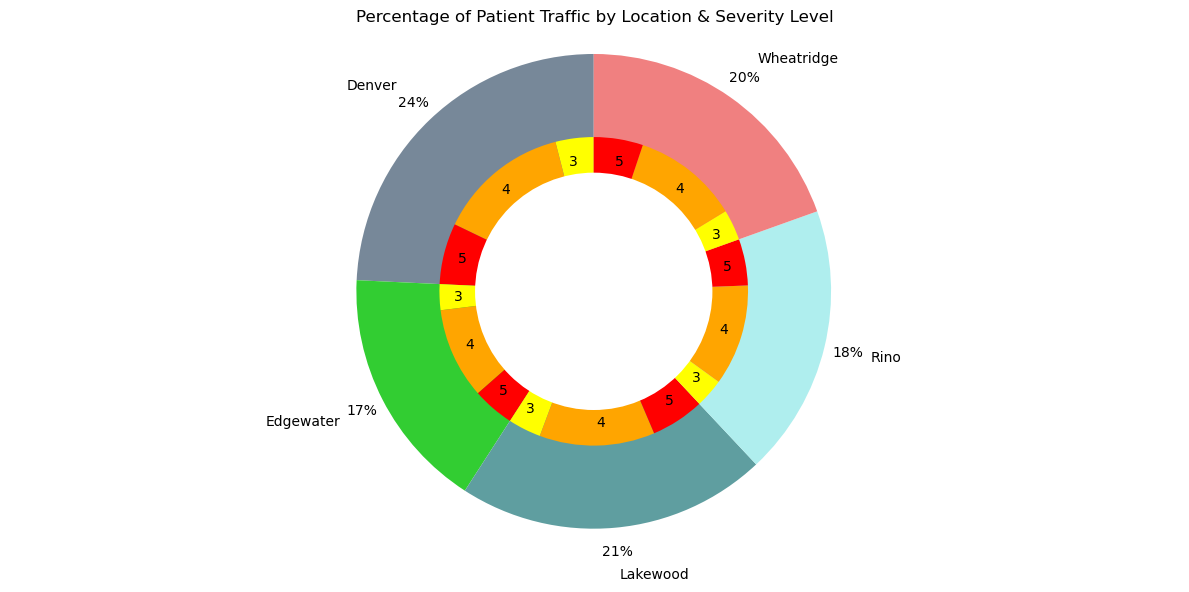

In [7]:
#### ALTERNATE VISUAL TO ABOVE

# Get counts of each class for outer-circle (visit_location) and inner-circle (visit_code)
outer_circle_counts = patients_df['visit_location'].value_counts().sort_index()
outer_circle_labels = outer_circle_counts.index.str.capitalize().values
inner_circle_counts = patients_df.groupby(['visit_location', 'visit_code']).count()['pt_name']
inner_circle_labels = [i[1] for i in inner_circle_counts.index.values]

# Custom specs
outer_colors = ['lightslategrey', 'limegreen', 'cadetblue', 'paleturquoise', 'lightcoral']
inner_colors = ['yellow', 'orange', 'red'] * int(len(outer_circle_counts) / 3)
explode_specs_outer = tuple([0.0] * int(len(outer_circle_counts)))
explode_specs_inner = tuple([0.0] * int(len(inner_circle_counts)))

# Plot outer and inner pie charts
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.pie(outer_circle_counts.values, colors=outer_colors, autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, explode=explode_specs_outer, labels=outer_circle_labels, startangle=90, frame=True) 
plt.pie(inner_circle_counts.values, colors=inner_colors, explode=explode_specs_inner, labels=inner_circle_labels, labeldistance=0.85, radius=0.65, startangle=90)
fig = plt.gcf()
fig.gca().add_artist(plt.Circle((0,0), 0.5, color='black', fc='white', linewidth=0))
plt.axis('equal')
plt.title(f'Percentage of Patient Traffic by Location & Severity Level')
plt.tight_layout()
plt.show()

The figure above breaks down the past year's patient records by clinic location & severity level. Denver's branch saw the most amount of patients, followed by Lakewood & Wheatridge. Edgewater saw the least amount of cases. All locations seem to have a similar proportion of severity levels for cases. As Denver is the most populated city, while Edgewater has the least amount of residents, this distribution follows the order closely.

In [8]:
df = patients_df.copy().sort_values(by='visit_code')
fig = px.histogram(df, x='visit_reason', text_auto=True, color='visit_code', color_discrete_sequence=['khaki', 'coral', 'firebrick'])
fig.update_layout(height=600, width=1200, title_text='Patient Count by Reason')
fig.update_xaxes(categoryorder='total ascending')
fig.show()

The figure above looks at patient visit reasons for all 5 clinics, broken down by severity level. Urgent cases that require emergency intervention are labeled as 5 whereas visits pertaining to non-urgent cases such as physicals or vaccinations are designed as 3. Majority of the cases are level-4 and therefore we can anticipate a consistent visit-time for these patients. 

In [9]:
fig = px.histogram(patients_df, x='pt_age', text_auto=False, color_discrete_sequence=['sandybrown'])
fig.update_layout(height=400, width=1000, title_text='Patient Count by Age')
fig.show()

The figure above displays the patient age distribution among all 5 clinics throughout the past year's records. Age group 20-30 saw the most patients and the distribution is mostly normal, with a slight right skew. Older patients typically represent a lesser proportion of urgent care traffic due to more specialized services available for them. 

#### Examine clinic traffic based on existing attributes:

In [10]:
fig = px.histogram(patients_df, x='rolling_ct', text_auto=False, color_discrete_sequence=['darkcyan'])
fig.update_layout(height=400, width=1000, title_text='Rolling Count')
fig.show()

In [11]:
fig = make_subplots(
    rows=3, cols=2, 
    specs=[[{'type':'xy'}, {'type':'xy'}], [{'type':'xy'}, {'type':'xy'}], [{'type':'xy'}, {'type':'xy'}]], 
    subplot_titles=["Denver's Rolling Count", "Edgewater's Rolling Count", "Wheatridge's Rolling Count", "RINO's Rolling Count", "Lakewood's Rolling Count"]
)

# Construct histogram for patient count by location stratified by severity level
hist1 = go.Histogram(x=patients_df[patients_df.visit_location=='denver']['rolling_ct'], marker_color='darksalmon')
hist2 = go.Histogram(x=patients_df[patients_df.visit_location=='edgewater']['rolling_ct'], marker_color='olivedrab')
hist3 = go.Histogram(x=patients_df[patients_df.visit_location=='wheatridge']['rolling_ct'], marker_color='royalblue')
hist4 = go.Histogram(x=patients_df[patients_df.visit_location=='rino']['rolling_ct'], marker_color='mediumpurple')
hist5 = go.Histogram(x=patients_df[patients_df.visit_location=='lakewood']['rolling_ct'], marker_color='khaki')

# Add subplots to figure object
fig.add_trace(hist1, row=1, col=1)
fig.add_trace(hist2, row=1, col=2)
fig.add_trace(hist3, row=2, col=1)
fig.add_trace(hist4, row=2, col=2)
fig.add_trace(hist5, row=3, col=1)

# Output figure with custom modifications
fig.update_layout(height=600, width=1100, showlegend=False)
fig.show()

From the figure above, we can observe the distributions of the rolling patient counts for each clinic. Although each of them are skewed right, it is immediately apparent that Denver tends to see a higher accumulation of patient count all the way upto 20 whereas the rest of the clinics max out around 15. Therefore, the Denver branch will naturally be more staffed and might involve more tech-navigation to meet its higher demand & daily traffic. 

---
---

## 2C: Aggregated Explorations

**Objective**: Closely examine relationships within the dataset through aggregated groupings & feature engineering.

---

#### Explore daily patient count aggregated by the day of the week:

In [12]:
# Track the number of days in past year broken down by the day of the week to feed as input into following aggregations
uniq_days = patients_df.groupby(['visit_date', 'visit_day']).count().reset_index(drop=False)[['visit_date', 'visit_day']]
print(uniq_days.visit_day.value_counts().to_dict())

{'Saturday': 53, 'Sunday': 52, 'Monday': 52, 'Tuesday': 52, 'Wednesday': 52, 'Thursday': 52, 'Friday': 52}


In [13]:
# Aggregate patients data based on daily count broken down by location and day of week
num_pts_per_day = patients_df.groupby(['visit_location', 'visit_day']).count()[['rolling_ct']].reset_index(drop=False)
num_pts_per_day['avg_num_pts'] = num_pts_per_day[['rolling_ct', 'visit_day']].apply(lambda x: round(x[0]/53, 1) if x[1] in ['Saturday'] else round(x[0]/52, 1), axis=1)

# Sort value types for plot outputs to be in desired order
num_pts_per_day['order'] = num_pts_per_day.visit_day.map({'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6})
num_pts_per_day = num_pts_per_day.sort_values(by='order')

# Plot average number of patients broken down by day of week, stratified by location
fig = px.bar(
    num_pts_per_day, x='visit_day', y='avg_num_pts', 
    color='visit_location', barmode='group', 
    text='avg_num_pts', title='Average Number of Patients per Day & Clinic',
    labels={'visit_day': 'Day of the Week', 'avg_num_pts': 'Avg. Number of Patients'}
)
fig.update_traces(textposition='outside', cliponaxis=False, textfont_size=10)
fig.show()

The figure above displays the average number of patients that visit each clinic, broken down by the day of the week. Based on this, it is apparent that the clinic location has more impact on expected number of patients rather than the day of the week.

#### Explore differences between weekday vs. weekend:

In [14]:
# Create attribute of boolean representing if visit_day falls on Saturday/Sunday
patients_df['weekend'] = patients_df.visit_day.map(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

# Aggregate patients day based on visit_day falling on weekday or weekend
weekend_df = patients_df.groupby(['visit_location', 'weekend']).count()[['rolling_ct']].reset_index(drop=False)
weekend_df['avg_num_pts'] = weekend_df[['rolling_ct', 'weekend']] \
    .apply(lambda x: round(x[0]/105, 1) if x[1] == 1 else round(x[0]/260, 1), axis=1)

# Plot average number of patients on weekdays and weekends, broken down by location
fig = px.bar(
    weekend_df, x='weekend', y='avg_num_pts', 
    color='visit_location', barmode='group', 
    text='avg_num_pts', title='Average Number of Patients Per Clinic (Weekdays vs Weekend)',
    labels={'weekend': 'Day Type', 'avg_num_pts': 'Avg. Number of Patients'}
)
for idx in range(len(fig.data)):
    fig.data[idx].x = ['Weekday', 'Weekend']
fig.update_traces(textposition='outside', cliponaxis=False, textfont_size=10)
fig.show()

The figure above confirms there is not much variation in number of patients seen based on day types, as the location seems to be the primary feature that dictates patient traffic.

#### Extract and explore total time patients spend in clinics:

In [15]:
# Create appt_time column (in minutes)
patients_df['appt_time'] = patients_df[['checkin_time', 'checkout_time']] \
    .apply(lambda x: datetime.strptime(x[1], '%H:%M:%S') - datetime.strptime(x[0], '%H:%M:%S'), axis=1) \
    .apply(lambda x: int(x.seconds/60))
patients_df

pt_name      pt_dob  pt_age visit_location    visit_reason  \
pt_id                                                                          
1000016   Anthony Johnson  1966-05-27      55         denver     vaccination   
1000017      Laura Wright  2010-08-21      11         denver       ache/pain   
1000008     Karen Donovan  1998-05-03      24         denver     sore-throat   
1000014        Janet Rowe  2003-10-18      18         denver  cold/flu/fever   
1000019    Jeffrey Landry  1997-10-13      24         denver           cough   
...                   ...         ...     ...            ...             ...   
5023104      James Henson  1944-10-19      77       lakewood    rash/allergy   
5023098     Carlos Brewer  1972-05-30      49       lakewood    cuts/abscess   
5023099      Cheryl Watts  2005-02-04      17       lakewood  cold/flu/fever   
5023102         Paul Buck  2003-02-04      19       lakewood     sore-throat   
5023100  Benjamin Watkins  1972-05-30      49       lakewood        lab-work   

         visit_code  visit_date visit_day checkin_time checkout_time  \
pt_id                                                                  
1000016           3  2021-05-01  Saturday     09:47:09      10:01:09   
1000017           4  2021-05-01  Saturday     10:51:09      11:28:09   
1000008           4  2021-05-01  Saturday     10:53:24      11:33:24   
1000014           4  2021-05-01  Saturday     10:58:30      12:07:30   
1000019           4  2021-05-01  Saturday     11:07:11      12:02:11   
...             ...         ...       ...          ...           ...   
5023104           5  2022-04-30  Saturday     19:42:10      20:32:58   
5023098           5  2022-04-30  Saturday     19:48:05      20:41:05   
5023099           4  2022-04-30  Saturday     19:49:17      21:01:29   
5023102           4  2022-04-30  Saturday     19:51:05      20:34:17   
5023100           3  2022-04-30  Saturday     19:53:19      20:42:19   

         rolling_ct  rolling_code  assigned_num_techs  needed_num_techs  \
pt_id                                                                     
1000016           1           0.0                   5                 1   
1000017           1           0.0                   5                 1   
1000008           2           4.0                   5                 1   
1000014           3           4.0                   5                 1   
1000019           4           4.0                   5                 2   
...             ...           ...                 ...               ...   
5023104           9           4.4                   4                 3   
5023098           9           4.5                   4                 3   
5023099          10           4.6                   4                 4   
5023102          10           4.6                   4                 4   
5023100          11           4.5                   4                 4   

         weekend  appt_time  
pt_id                        
1000016        1         14  
1000017        1         37  
1000008        1         40  
1000014        1         69  
1000019        1         55  
...          ...        ...  
5023104        1         50  
5023098        1         53  
5023099        1         72  
5023102        1         43  
5023100        1         49  

[109363 rows x 16 columns]

In [16]:
# Average appointment time per visit code, per location
appt_times_df = patients_df.groupby(['visit_code']).mean()['appt_time'].reset_index(drop=False)

# Plot average appt time per visit code
fig = px.bar(appt_times_df, x='visit_code', y='appt_time', title='Average Appt. Time per Severity Level')
fig.update_layout(height=400, width=1100, showlegend=True)
fig.show()

The figure above shows the the average visit time for patients based on the severity level of their reason. As expected, the appointment time increases with the designated visit code. However, more interestingly, there is a bigger bump between level 4 & 5 than there is going from 3 to 4, confirming that code-5 visits are time consuming and require adequate staffing to ensure efficiency.

In [17]:
# Average appointment time per reason, per location
appt_times_df = patients_df.groupby(['visit_location', 'visit_reason']).mean()[['appt_time']].reset_index(drop=False)

# Plot average appointment time broken down by reason and clinic location
fig = make_subplots(
    rows=5, cols=1, shared_xaxes=False, #, vertical_spacing=0.02,
    specs=[[{'type':'xy'}], [{'type':'xy'}], [{'type':'xy'}], [{'type':'xy'}], [{'type':'xy'}]]
)

# Define iterables for plotting configurations
cities = ['denver', 'edgewater', 'wheatridge', 'rino', 'lakewood']
colors = ['chocolate', 'olivedrab', 'royalblue', 'dimgray', 'darksalmon']

# Construct plot for patient count by location stratified by severity level
for i in range(5):
    
    # Plot points
    df = appt_times_df[appt_times_df.visit_location == cities[i]]
    s = go.Scatter(
        x=df['visit_reason'], y=df['appt_time'], 
        marker_color=colors[i], mode='markers', marker_size=10, 
        name=f"{cities[i].capitalize()}'s Avg. Appt. Times"
    )
    
    # Add lines leading upto the scatter points
    for j in range(len(df)):
        fig.add_shape(
            type='line', x0=j, y0=0,
            y1=df['appt_time'].values[j], x1=j,
            line=dict(color=colors[i], width=3), 
            row=i+1, col=1
        )
    
    fig.add_trace(s, row=i+1, col=1)

# Output figure with custom modifications
fig.update_layout(height=1200, width=1100, showlegend=True)
fig.show()

The figure above allows for a closer examination of visit times based on each individual clinic. Although the overall inter-reason patterns are largely the same, there are slight variations in inter-clinic comparisons.

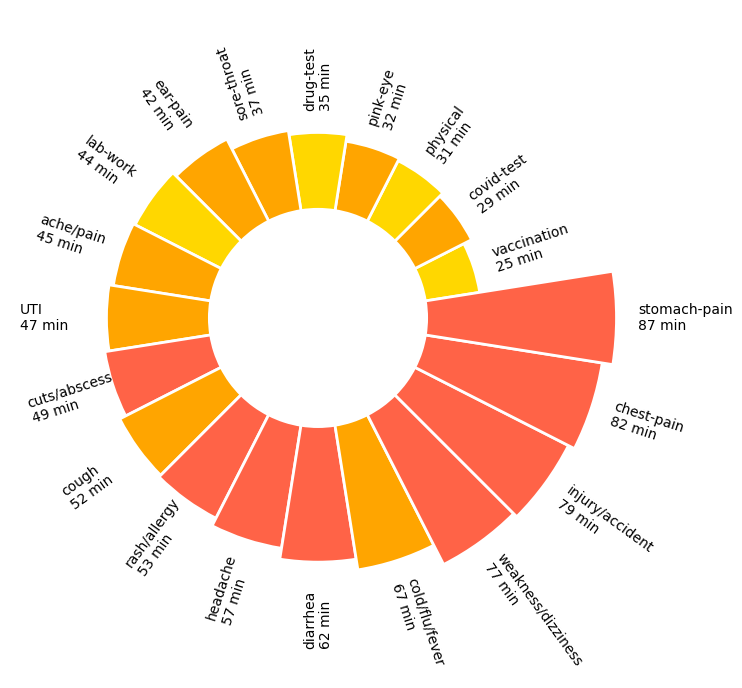

In [18]:
# Average appointment time per visit code, per location
appt_times_df = patients_df.groupby(['visit_reason', 'visit_code']).mean()['appt_time'].reset_index(drop=False)

# # Sort appt times for sorted graph
appt_times_df = appt_times_df.sort_values(by=['appt_time'])

### Plot average appt time per visit code

fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Polar axis
ax = plt.subplot(111, polar=True)
plt.axis('off')  # remove axis display

# Retrieve width measure & corresponding angles for each bar 
bar_width = 2*np.pi / len(appt_times_df.index)
center_angles = [i * bar_width for i in list(range(1, len(appt_times_df.index)+1))]

# Plot the appointment times
colors = appt_times_df.visit_code.map({3: 'gold', 4: 'orange', 5: 'tomato'})
bars = ax.bar(
    x=center_angles, 
    height=appt_times_df['appt_time'], 
    width=bar_width, 
    bottom=50,
    linewidth=2, 
    edgecolor='white',
    color=colors
)

# Generate corresponding labels on plot display
for i in range(len(appt_times_df)):
    
    # Define specs for label and desired rotation
    label = f"{appt_times_df['visit_reason'].values[i]}\n{int(appt_times_df['appt_time'].values[i])} min"
    rot = np.rad2deg(center_angles[i])
    spacing = 60
    if i > 5 and i < 15:  # for down-left labels, flip rotation for easier reading
        rot = rot + 180
        spacing = 90
        
    ax.text(
        x=center_angles[i], 
        y=bars[i].get_height()+spacing, 
        s=label, 
        va='center', 
        rotation=rot, 
        rotation_mode="anchor",
    ) 

The figure above breaks down the average visit times based on the specific reasons for cumulative clinic data. Chest-pain, stomach-pains, and injuries are among reasons that take up the largest amount of visit time, which intuitively makes sense since these visits often require additional diagnostic measures such as imaging and blood-work, as well as, more advanced therapeutics such as IV-fluids, or even hospital transfers.

---
---

## 2D: Daily Influx Explorations

**Objective**: Visually explore patient influx rate to inform scheduler process.

---

In [19]:
# Create iterable objects that are desired for toggle menus
locations = patients_df.visit_location.unique().tolist()
dates = patients_df.visit_date.unique().tolist()
# fig = go.FigureWidget()

@interact(date=dates, first_location=locations, second_location=locations)
def generate_daily_dist(date=dates[0], first_location=locations[0], second_location=locations[1]):
    """Produces rolling-count distributions that can be toggled through for specific locations & dates."""
    fig = go.FigureWidget()

    # with fig.batch_update():
    
    # Convert specific times to grouped versions
    df = patients_df.copy()
    df['checkin_time'] = df.checkin_time.apply(lambda x: x[:-3])

    # Create subset data for desired date and the two locations to compare
    df1 = df[(df.visit_date == date) & (df.visit_location == first_location)]
    df2 = df[(df.visit_date == date) & (df.visit_location == second_location)]

    # Construct barplot for patient count by location stratified by severity level
    bar1 = go.Bar(
        x=df1['checkin_time'], y=df1['rolling_ct'], 
        name=f'Pt. Count @ {first_location.capitalize()} clinic', marker_color='red'
    )
    bar2 = go.Bar(
        x=df2['checkin_time'], y=df2['rolling_ct'], 
        name=f'Pt. Count @ {second_location.capitalize()} clinic', marker_color='blue'
    )

    # Add subplots to figure object
    fig.add_trace(bar1)
    fig.add_trace(bar2)

    # Output figure with custom modifications
    order = sorted(df1.checkin_time.tolist() + df2.checkin_time.tolist())
    fig.update_xaxes(categoryorder='array', categoryarray=order)
    fig.update_traces(opacity=0.3)
    fig.update_layout(height=500, width=1200, showlegend=True, barmode='overlay')
    fig.show()
        
# fig

interactive(children=(Dropdown(description='date', options=('2021-05-01', '2021-05-02', '2021-05-03', '2021-05…

The interactive widget above lets us explore the rolling patient count of two clinics for any date to examine the influx patterns and determine the potency of tech-navigation in these settings. Toggling between various clinics and dates shows that due to the randomness of patient influx, there are busy and less-busy waves between particular clinics that can be strategically utilized for staff navigation to optimize productivity and reduce operational costs. 

---
---

## 2E: Scheduling-Inefficiencies Explorations

**Objective**: As a supplmentary visual to patient influx, explore the technician counts vs. technicians needed for a given location & date.

---

In [20]:
# Create iterable objects that are desired for toggle menus
locations = patients_df.visit_location.unique().tolist()
dates = patients_df.visit_date.unique().tolist()
# fig = go.FigureWidget()

@interact(date=dates)
def generate_staff_count_visual(date=dates[0]):
    """Produces rolling staff-count needed that can be toggled through for specific locations & dates."""
    
    fig = go.FigureWidget()
    
    fig = make_subplots(
    rows=5, cols=1, 
    specs=[[{'type':'xy'}], [{'type':'xy'}], [{'type':'xy'}], [{'type':'xy'}], [{'type':'xy'}]], 
    subplot_titles=["Denver", "Edgewater", "Wheatridge", "RINO", "Lakewood"]
    )
    
    # Plot for each location
    for i in range(5):
        
        location = locations[i]
        
        # Convert specific times to grouped versions
        df = patients_df.copy()
        df['checkin_time'] = df.checkin_time.apply(lambda x: x[:-3])

        # Create subset data for desired date and the two locations to compare
        df = df[(df.visit_date == date) & (df.visit_location == location)]

        # Construct lineplot for tech-count by location & time
        line1 = go.Scatter(
            x=df['checkin_time'], y=df['assigned_num_techs'], 
            name=f'Assigned Number of Techs @ {location.capitalize()} clinic', marker_color='red', legendgroup=i+1, mode='markers'
        )
        line2 = go.Scatter(
            x=df['checkin_time'], y=df['needed_num_techs'], 
            name=f'Needed Number of Techs @ {location.capitalize()} clinic', marker_color='green', legendgroup=i+1, mode='lines'
        )

        # Add subplots to figure object
        fig.add_trace(line1, row=i+1, col=1)
        fig.add_trace(line2, row=i+1, col=1)

    # Output figure with custom modifications
    fig.update_traces(opacity=0.3)
    fig.update_layout(height=1500, width=1200, showlegend=True, legend_tracegroupgap=250)
    fig.show()
        
# fig

interactive(children=(Dropdown(description='date', options=('2021-05-01', '2021-05-02', '2021-05-03', '2021-05…

The above charts that can be toggled based on any desired date shows the assignment number of techs at a particular clinic location and the rolling "needed" number of techs (computed based on the real-time number of patients in clinic at that moment). These plots are to illustrate the inefficiencies that currently exist for the client and the purpose for optimization through this project. Based on above, it is immediately apparent that the current staff assignments can be heavily reduced, if we can control for the peak times and schedule staff based on average patient counts instead. 

---
---

## 2F: Geographic Explorations

**Objective**: Explore dataset attributes within a geospatial context.

---

#### Construct Folium map that indicates a clinic's patient influx for a particular date & time:

In [21]:
# Create iterable objects that are desired for toggle menus
dates = patients_df.visit_date.unique().tolist()
times = { '08': '8am', '09': '9am', '10': '10am', '11': '11am', '12': '12pm', '13': '1pm', 
          '14': '2pm', '15': '3pm', '16': '4pm', '17': '5pm', '18': '6pm', '19': '7pm', '20': '8pm'}

@interact
def map_daily_influx(date=dates, time=list(times.values())):
    """Produces Folium map of each clinic with indicated influx level based on date & time of interest."""
    
    df = patients_df.copy()
    
    # Bin check-in times by hour and get max rolling_ct of hour for simpler visual
    df['checkin_time'] = df.checkin_time.apply(lambda x: x[:2])
    df['checkin_time'] = df.checkin_time.map(times)
    df = df.groupby(['visit_location', 'visit_date', 'checkin_time']).max()[['rolling_ct']].reset_index(drop=False)
    
    # Gather clinic coordinates for map
    df['lat'] = df.visit_location.map(clinics_df.to_dict()['lat'])
    df['lon'] = df.visit_location.map(clinics_df.to_dict()['lon'])
    
    # Filter dataframe based on desired input date and time
    df = df[(df.visit_date == date) & (df.checkin_time == time)]
    
    # Duplicate records based on rolling count of patients for cluster-map
    df = df.loc[df.index.repeat(df['rolling_ct'])]

    # Instantiate Folium map based on Denver, CO's base coordinates
    m = folium.Map(location=[39.74, -105], zoom_start=13, min_zoom=10, max_zoom=14)
    marker = plugins.MarkerCluster(name='Patient Count').add_to(m)
    
    # Add a marker for every record in the filtered data, use a clustered view
    for row in df.iterrows():
        folium.Marker(location=[row[1]['lat'], row[1]['lon']]).add_to(marker)
    
    folium.LayerControl().add_to(m)

    display(m)

interactive(children=(Dropdown(description='date', options=('2021-05-01', '2021-05-02', '2021-05-03', '2021-05…

The interactive widget above lets us visualize the geographic locations of each clinic & explore the rolling patient count at any desired time. Toggling between different dates and times shows the "real-time" status of patient influx with green-orange-red colors indicating a major uptick in count. This allows for an easier understanding of the advantages of tech-navigation to fulfill the needs of swarmed clinics while maintaining productivity at less-busy locations.